In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

/root/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
plt.rcParams['font.size'] = 12

In [3]:
data = pd.DataFrame({   
    'yield':[7, 13, 13, 11, 5, 6, 8, 11, 10, 11,
             11, 11, 11, 14, 8, 15, 10, 9, 13, 12,
             8, 15, 7, 11, 5, 11, 15, 10, 13, 9,
             8, 12, 13, 6, 8, 5, 13, 8, 5, 10,
             18, 9, 7, 12, 11, 5, 9, 10, 13, 13,
             7, 12, 8, 16, 10, 6, 12, 13, 10, 12, 
             9, 7, 12, 11, 8, 15, 13, 11, 9, 17,
             11, 10, 15, 19 ,11, 13, 12, 9, 10,10],

    'group':[0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,
             1,1,1,1,1,1,1,1,1,1,
             1,1,1,1,1,1,1,1,1,1,
             ]    
})

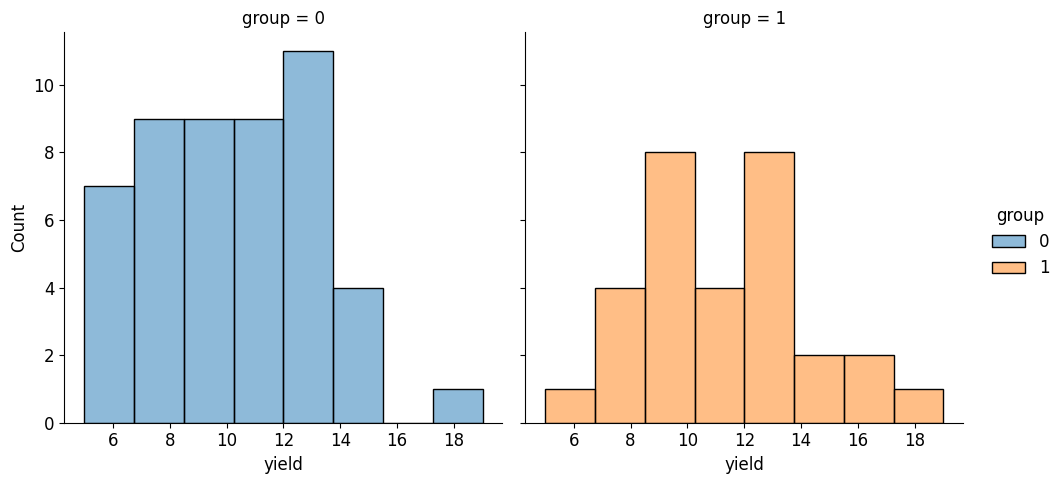

In [5]:
sns.displot(data=data, x='yield', hue='group', col='group')

In [6]:
data.groupby('group').mean()

,yield
group,
0,10.160000
1,11.266667


In [7]:
y = data['yield'].values
g = data['group'].values

#### 二つの事前分布が必要

In [10]:
def model(y=None, g=None, num_data=0):
    mu = numpyro.sample('mu', dist.HalfNormal(10), sample_shape=(2,))
    
    mu_dup = mu[g]
    
    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Poisson(mu_dup), obs=y)
        
    mu_diff = numpyro.deterministic('mu_diff', mu[1]-mu[0])    

In [11]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), y=y, g=g, num_data=len(y))
mcmc.samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

/tmp/ipykernel_409/3298058293.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)
sample: 100% 3500/3500 [00:30<00:00, 115.12it/s, 3 steps of size 9.68e-01. acc. prob=0.91] 
sample: 100% 3500/3500 [00:28<00:00, 120.74it/s, 7 steps of size 9.12e-01. acc. prob=0.91] 
sample: 100% 3500/3500 [00:32<00:00, 107.39it/s, 3 steps of size 8.65e-01. acc. prob=0.92]
sample: 100% 3500/3500 [00:32<00:00, 108.54it/s, 3 steps of size 8.86e-01. acc. prob=0.92] 


array([[<AxesSubplot: title={'center': 'mu'}>,
        <AxesSubplot: title={'center': 'mu'}>],
       [<AxesSubplot: title={'center': 'mu_diff'}>,
        <AxesSubplot: title={'center': 'mu_diff'}>]], dtype=object)

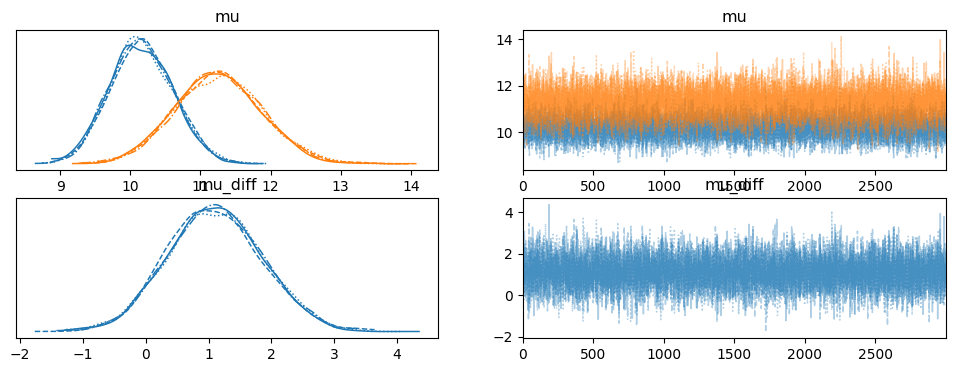

In [12]:
az.plot_trace(idata)

Text(0.5, 0, '$\\lambda_1 - \\lambda_0$')

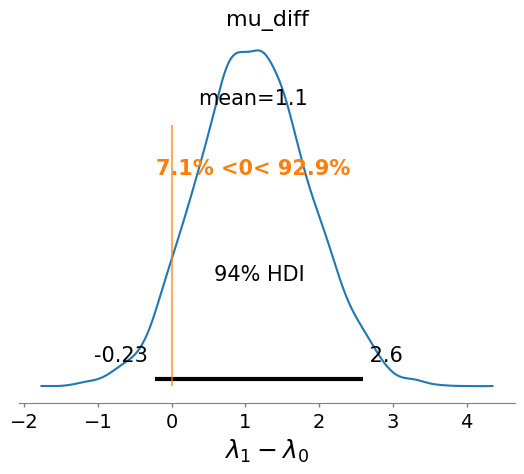

In [13]:
az.plot_posterior(idata, var_names=['mu_diff'], ref_val=0)

plt.xlabel('$\lambda_1 - \lambda_0$', fontsize=18)